In [33]:
#importing all the important libraries
import os
import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot
from keras.preprocessing import image
from scipy.misc import toimage
from random import shuffle
import cv2
from keras.preprocessing.image import ImageDataGenerator #for data augmentation
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as k
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# importing the data sets

In [2]:
train_path = '/home/prateeksha/Downloads/kaggle/catsvsdogs/train'
train_labels = os.listdir(train_path)
train_labels[1]
len(train_labels)

25000

# trying to plot some images of cats and dogs

/home/prateeksha/Downloads/kaggle/catsvsdogs/train/dog.10003.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/cat.2050.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/dog.8817.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/cat.8511.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/cat.4032.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/cat.9604.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/cat.243.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/dog.10188.jpg
/home/prateeksha/Downloads/kaggle/catsvsdogs/train/dog.1386.jpg


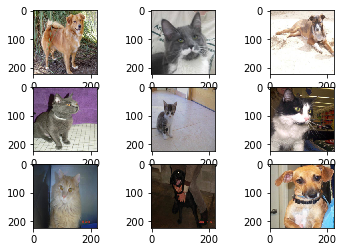

In [3]:
for i in range(0, 9):
    label = train_labels[i]
    cur_path = train_path + "/" + label
    print cur_path
    img = image.load_img(cur_path, target_size=(224,224))
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(toimage(img))
# show the plot
pyplot.show()


# creating labels

In [4]:
y_train = []
for i,img in enumerate(train_labels):
    split = img.split(".")
    split = split[0]
    #print split
    if split == 'cat': num = 1
    #                             [no cat, very doggo]
    elif split == 'dog': num=0
    y_train.append(num)
len(y_train)
    
    
    

25000

In [5]:
y_train[:9]

[0, 1, 0, 1, 1, 1, 1, 0, 0]

# loading the images 

In [6]:
x_train = []
for i,img in enumerate(train_labels):
    path = os.path.join(train_path, img)
    img = image.load_img(path, target_size = (14,14))
    img = img_to_array(img)
    x_train.append(img)
    if i%1000 == 0: print('Processed {} of {}'.format(i, 25000))
    
print(x_train[0].shape)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000
(14, 14, 3)


# splitting the data into train and cv sets

In [11]:
(trainX, testX, trainY, testY) = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)


In [12]:
img_rows, img_cols = 14, 14
if k.image_data_format() == 'channels_first':
    trainX = trainX.reshape(trainX.shape[0], 3, img_rows, img_cols)
    testX = testX.reshape(testX.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    trainX = trainX.reshape(trainX.shape[0], img_rows, img_cols, 3)
    testX = testX.reshape(testX.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# bringing in the format for feeding in the network

In [13]:
x_train = np.array(x_train, dtype="float")/255.0
y_train = np.array(y_train)
print x_train.shape


#we need to hot-encode the labels  
trainY = keras.utils.to_categorical(trainY, num_classes = 2)
testY = keras.utils.to_categorical(testY, num_classes =2)



(25000, 14, 14, 3)


In [14]:
print(testY.shape)

(6250, 2)


# data augmentation by shifting, shearing, zooming and flipping

In [15]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range = 0.1,shear_range = 0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [16]:
aug.fit(trainX)

# building a simple keras model

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape= input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense( 2, activation='softmax'))

In [21]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])

In [22]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    history = LossHistory()
    model.fit_generator(aug.flow(trainX, trainY, batch_size = 32 ), validation_data = (testX, testY), steps_per_epoch = len(trainX)//32, callbacks= [history], epochs = 10, verbose =1)
   
   

    #predictions = model.predict(test, verbose=0)
    return  history
history = run_catdog()

Epoch 1/10
585/585 [==============================] - 23s 40ms/step - loss: 0.6888 - acc: 0.5349 - val_loss: 0.6815 - val_acc: 0.5277
Epoch 2/10
585/585 [==============================] - 22s 37ms/step - loss: 0.6761 - acc: 0.5753 - val_loss: 0.6795 - val_acc: 0.5573
Epoch 3/10
585/585 [==============================] - 20s 34ms/step - loss: 0.6645 - acc: 0.5952 - val_loss: 0.6479 - val_acc: 0.6216
Epoch 4/10
585/585 [==============================] - 21s 37ms/step - loss: 0.6531 - acc: 0.6142 - val_loss: 0.6081 - val_acc: 0.6662
Epoch 5/10
585/585 [==============================] - 22s 38ms/step - loss: 0.6367 - acc: 0.6362 - val_loss: 0.6030 - val_acc: 0.6701
Epoch 6/10
585/585 [==============================] - 23s 39ms/step - loss: 0.6246 - acc: 0.6516 - val_loss: 0.5854 - val_acc: 0.6843
Epoch 7/10
585/585 [==============================] - 23s 40ms/step - loss: 0.6179 - acc: 0.6601 - val_loss: 0.5840 - val_acc: 0.6845
Epoch 8/10
585/585 [==============================] - 26s 45ms

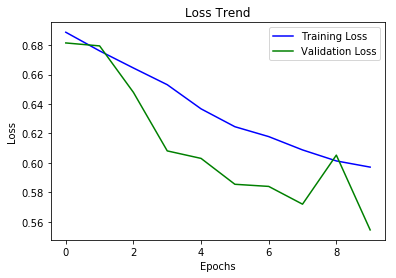

In [23]:
loss = history.losses
val_loss = history.val_losses

pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Loss Trend')
pyplot.plot(loss, 'blue', label='Training Loss')
pyplot.plot(val_loss, 'green', label='Validation Loss')
pyplot.xticks(range(0,10)[0::2])
pyplot.legend()
pyplot.show()

# using batch normalisation

In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape= input_shape))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(512, init ='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128, init ='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense( 2, activation = 'softmax')) # batchnorm shouldn't be applied at the last layer 




/home/prateeksha/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="uniform")`
/home/prateeksha/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="uniform")`


In [29]:
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics =['accuracy'])

In [30]:

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    history = LossHistory()
    model.fit_generator(aug.flow(trainX, trainY, batch_size = 32 ), validation_data = (testX, testY), steps_per_epoch = len(trainX)//32, callbacks= [history], epochs = 10, verbose =1)
   
   

    #predictions = model.predict(test, verbose=0)
    return  history
history = run_catdog()

Epoch 1/10
585/585 [==============================] - 19s 33ms/step - loss: 0.7668 - acc: 0.5273 - val_loss: 0.6787 - val_acc: 0.5656
Epoch 2/10
585/585 [==============================] - 17s 30ms/step - loss: 0.6795 - acc: 0.5712 - val_loss: 0.6945 - val_acc: 0.5557
Epoch 3/10
585/585 [==============================] - 19s 32ms/step - loss: 0.6513 - acc: 0.6196 - val_loss: 0.6356 - val_acc: 0.6307
Epoch 4/10
585/585 [==============================] - 19s 32ms/step - loss: 0.6321 - acc: 0.6446 - val_loss: 0.5880 - val_acc: 0.6859
Epoch 5/10
585/585 [==============================] - 19s 32ms/step - loss: 0.6161 - acc: 0.6619 - val_loss: 0.6621 - val_acc: 0.6133
Epoch 6/10
585/585 [==============================] - 20s 34ms/step - loss: 0.6127 - acc: 0.6654 - val_loss: 0.5712 - val_acc: 0.6976
Epoch 7/10
585/585 [==============================] - 21s 35ms/step - loss: 0.6038 - acc: 0.6754 - val_loss: 0.6317 - val_acc: 0.6520
Epoch 8/10
585/585 [==============================] - 19s 33ms

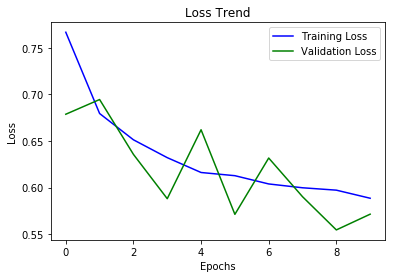

In [31]:
loss = history.losses
val_loss = history.val_losses

pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Loss Trend')
pyplot.plot(loss, 'blue', label='Training Loss')
pyplot.plot(val_loss, 'green', label='Validation Loss')
pyplot.xticks(range(0,10)[0::2])
pyplot.legend()
pyplot.show()

In [36]:
df = pd.read_csv('/home/prateeksha/Downloads/sample_submission.csv')
df.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [41]:
test_path = '/home/prateeksha/Downloads/kaggle/catsvsdogs/test'
test_labels = os.listdir(test_path)
print(test_labels[1])

4949.jpg


In [38]:
id = []
for i,img in enumerate(test_labels):
    split = img.split(".")
    split = split[0]
    
    id.append(split)
len(id)
    
    

12500

In [45]:
test_img = []
for i,img in enumerate(test_labels):
    path = os.path.join(test_path, img)
    img = image.load_img(path, target_size = (14,14))
    img = img_to_array(img)
    test_img.append(img)
    if i%1000 == 0: print('Processed {} of {}'.format(i, 12500))
    
print(test_img[0].shape)

Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500
(14, 14, 3)


In [48]:
img_rows, img_cols = 14, 14
if k.image_data_format() == 'channels_first':
    test_img = test_img.reshape(test_img.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    test_img = test_img.reshape(test_img.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [49]:
test_img = np.array(test_img, dtype="float")/255.0

print test_img.shape


(12500, 14, 14, 3)
